# Market research project
__Explanatory Data Analysis, by Chihebeddine HAMMAMI__

## Setup

In [0]:
import os

import numpy as np
import pandas as pd

# For DataViz
import matplotlib.pyplot as plt
import seaborn as sns

import re # For text handling

# For data set splitting
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# To render plots inside notebooks
%matplotlib inline

In [0]:
# Parameters
PATH = './../data/raw/'
TRAIN_FILE_NAME = "mower_market_snapshot.csv"
TEST_FILE_NAME = "submission_set.csv"
FIGS_PATH = './../figs'
TRAINING_TEST_RATIO = 0.2

## Framing the business problem

The objective of this study is to understand mower market dynamics in order enhance __product targetting and customers satisfaction__.

The starting point is a a data set containing mower data from many manufacturers with their given features. The final goal is to provide a predictive model to predict market share or equivalently attractiveness of a mower product given its characteristics.

## Getting data

In [0]:
def get_data(path, file_name):
    """
    Reads csv file
    
    """
    file_path = os.path.join(path, file_name)
    df = pd.read_csv(filepath_or_buffer = file_path, sep = ';')
    return df

In [0]:
raw_mower_data = get_data(PATH,TRAIN_FILE_NAME)
raw_mower_data.head()

,capacity,failure_rate,id,margin,price,prod_cost,product_type,quality,warranty,market_share,attractiveness
0,10.492623,0.042528,18377,633.766584,828.802103,195.03551928211797,auto-portee,Low,3ans,0.006360,0.650648
1,20.273730,0.037896,19363,731.576817,882.894916,151.31809934886763,auto-portee,Low,3 ans.,0.006840,0.699792
2,20.190457,0.039111,19641,741.218202,919.355522,178.13731921134948,auto-portee,Low,3_ans,0.006179,0.632129
3,27.220131,0.041303,18728,654.255635,817.085097,162.82946157588628,auto-portee,Low,3 anss,0.007925,0.810730
4,16.370911,0.037938,18722,703.094527,844.581465,141.48693796090603,auto-portee,Medium,3ans.,0.007406,0.757614


## Data exploration

### Features analysis

In [0]:
n, p  = raw_mower_data.shape
print (f'The data set contains {n} rows and {p-1} features for each mower')

The data set contains 1399 rows and 10 features for each mower


In [0]:
def get_missing_values_stats(df):
    """
    Get missing values stats for every column in df
    
    """
    n, _ = df.shape
    columns = df.columns
    na_count = raw_mower_data.apply(lambda c: sum(c.isna()))
    na_ratio = round(100*na_count/n,2)
    na_stats = pd.DataFrame({'Missing values count (#)': na_count,
                'Missing values ratio (%)': na_ratio})
    
    return na_stats.sort_values(by  = "Missing values ratio (%)",
                                ascending=False)

In [0]:
na_stats = get_missing_values_stats(raw_mower_data)
na_stats
# Prod cost missing values has to be handled properly

,Missing values count (#),Missing values ratio (%)
prod_cost,18,1.29
capacity,0,0.00
failure_rate,0,0.00
id,0,0.00
margin,0,0.00
price,0,0.00
product_type,0,0.00
quality,0,0.00
warranty,0,0.00
market_share,0,0.00


In [0]:
# Checking ids are unique to be used as index later on
try:
    assert raw_mower_data["id"].nunique()== n
except AssertionError as e:
    print('Id column is not uniquely defining instances')

In [0]:
# There are 3 markets (or product types) targeted for this study
# This feature is to be considered as a nominal categorical feature
raw_mower_data.product_type.unique()

array(['auto-portee', 'electrique', 'essence'], dtype=object)

In [0]:
# There are 3 product quality levels:
# This feature is to be considered as a ordinal categorical variable
# The typo 'height' is to corrected
raw_mower_data.quality.unique()

array(['Low', 'Medium', 'Hight'], dtype=object)

In [0]:
# Warranty needs to be handled properly to extract duration as an integer
raw_mower_data.warranty.unique()

array(['3ans', '3 ans.', '3_ans', '3 anss', '3ans.', '3 ans', '3_ans.',
       '3_anss', '3anss', '2 ans', '2 anss', '2anss', '2_ans', '2ans',
       '2_ans.', '2 ans.', '2_anss', '2ans.', '1 an', '1an', '1_an.',
       '1ans', '1an.', '1_ans', '1_an', '1 an.', '1 ans'], dtype=object)

In [0]:
def is_numeric_like(x):
    """
    Test wether `x` is numeric like
    """
    regex = '[0-9]+(\.)?[0-9]*'
    if re.fullmatch(regex,str(x)):
        return True
    else:
        return False

In [0]:
# Check what are the non numeric values
non_numeric_idx = raw_mower_data.prod_cost.apply(is_numeric_like)

raw_mower_data.prod_cost[~non_numeric_idx].unique()
# "These values has to be handled in data processing part"

array(['-64', 'unknown', nan], dtype=object)

### Training / Test sets split

- Before engaging more with data exploration and starting to spot patterns that generalize poorly, I would rather start by setting aside a test set to evalute model before submission.

- To do so, I noted that the data set is rather unbalanced with regard to an important feature: `prod_type` which define the dynamics of the market (Check the figure below)

- To ensure training set is representative of this stratification, I use stratified train/test split rather than random split, the effect of this can be checked in the next cells.

In [0]:
# Startified Training/test split based on `product_type`
spliter = StratifiedShuffleSplit(n_splits=1, test_size=TRAINING_TEST_RATIO, random_state = 42)
for train_index, test_index in spliter.split(raw_mower_data, raw_mower_data["product_type"]):
    strat_train_set = raw_mower_data.iloc[train_index]
    strat_test_set = raw_mower_data.iloc[test_index]

# Random Training/test split
random_train_set, random_test_set  = train_test_split(raw_mower_data, test_size=TRAINING_TEST_RATIO, random_state = 42)    

In [0]:
# Effect of Stratified train test split
def get_proportion(df, feature):
    
    """
    Get the proportion of `feature` in `df`
    """
    
    n, _ = df.shape
    return round(100*df[feature].value_counts()/n,2)

In [0]:
dfs = {"Strat. training":strat_train_set,"Strat. test": strat_test_set,
        "Random training": random_train_set,"Random test" : random_test_set}

splitting_res = {}
global_proportions = get_proportion(raw_mower_data, "product_type")

for ds in dfs:
    splitting_res[ds] = np.abs(get_proportion(dfs[ds],"product_type") - global_proportions)
splitting_res = pd.DataFrame(splitting_res)
splitting_res

,Strat. training,Strat. test,Random training,Random test
essence,0.01,0.03,0.28,1.10
electrique,0.03,0.12,0.06,0.23
auto-portee,0.04,0.15,0.22,0.86


The table show that Stratified splitting preserves `product_type` proportion, and ensure train is representative of the global data set.

## Data preprocessing

### Preliminary data preprocessing (Part 1)

__Suggested pre-processing transformations__

- Use id as an index for the DataFrame
- Handle and parse warranty to be an ordinal categorical variable instead of a string
- Handle anomalic feature value for prod_cost
- Handle displayed floating precision

In [0]:
# Set id as index
train = strat_train_set.set_index('id')

In [0]:
# Coerce to numeric values if possible otherwise return np.nan
train["prod_cost"] = pd.to_numeric(train["prod_cost"], "coerce")

In [0]:
def parse_warranty(x):
    """
    parse warranty string format
    """
    m = re.search('^[0-9]+',x)
    return int(m.group(0))

In [0]:
# Handle warranty column diverse formats
train["warranty"] = train["warranty"].apply(parse_warranty)

In [0]:
# Handle displayed floating precision
train.select_dtypes('float').head()

,capacity,failure_rate,margin,price,prod_cost,market_share,attractiveness
id,,,,,,,
19117,65.403063,0.274058,56.701880,65.924984,9.223105,0.001527,0.805758
18954,57.334169,0.258923,57.135618,68.204512,11.068895,0.001508,0.795371
19516,37.986082,0.036064,694.188403,839.296139,145.107736,0.006543,0.669369
19244,83.650827,0.234444,64.377874,75.889245,11.511371,0.001316,0.694472
18519,67.384377,0.208878,59.343337,72.026295,12.682958,0.001531,0.807660


In [0]:
# Correct `quality` typo from Hight to High
tmp = train.quality.copy()
train.quality = tmp.apply(lambda x: 'High' if x.lower() =="hight" else x)

In [0]:
# Handle floating precision at display round at 2 dgits
num_cols = list(train.select_dtypes('float').columns)
tmp = train.loc[:,num_cols].applymap(lambda x: round(x,2))
train.loc[:,num_cols] = tmp

## Explanatory data analysis

### Global trends

In [0]:
train.head()

,capacity,failure_rate,margin,price,prod_cost,product_type,quality,warranty,market_share,attractiveness
id,,,,,,,,,,
19117,65.40,0.27,56.70,65.92,9.22,essence,Low,1,0.00,0.81
18954,57.33,0.26,57.14,68.20,11.07,essence,Medium,1,0.00,0.80
19516,37.99,0.04,694.19,839.30,145.11,auto-portee,Low,3,0.01,0.67
19244,83.65,0.23,64.38,75.89,11.51,essence,Medium,1,0.00,0.69
18519,67.38,0.21,59.34,72.03,12.68,essence,Low,1,0.00,0.81


In [0]:
train.describe()

,capacity,failure_rate,margin,price,prod_cost,warranty,market_share,attractiveness
count,1119.000000,1119.000000,1119.000000,1119.000000,1094.000000,1119.000000,1119.000000,1119.000000
mean,47.797855,0.166461,186.249866,260.315594,55.932422,1.498660,0.001019,0.637775
std,19.770684,0.073583,191.078082,259.273203,61.334721,0.673912,0.003026,0.124588
min,0.010000,0.030000,52.940000,62.860000,-64.000000,1.000000,0.000000,0.300000
25%,36.020000,0.100000,62.380000,73.520000,10.692500,1.000000,0.000000,0.550000
50%,50.690000,0.200000,66.400000,78.440000,12.220000,1.000000,0.000000,0.640000
75%,62.015000,0.230000,264.150000,383.580000,113.827500,2.000000,0.000000,0.730000
max,104.610000,0.300000,775.840000,945.610000,210.140000,3.000000,0.010000,0.950000


### Univatriate data analysis

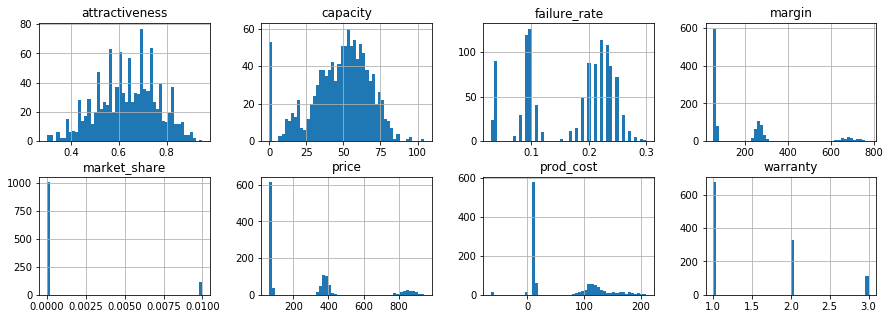

In [0]:
# Numeric features histograms
train.hist(figsize = (15,5), layout = (2,4), bins = 50);

__Features distribution analysis__:

- `attractiveness`: The target variable is bell shaped like distributed ranging from 0.3 to 0.95. But it seems to have at least two main clusters (to be investigated with regard of other features.


- `capacity`: also is exihibiting at least 3 distinct clusters:
    - a significant cluster around 0L capacity
    - a minor cluster centered 12.5L capacity
    - a the main cluster centered 50L capacity


- `failure_rate`: also is exihibiting at least 3 distinct and equally significant clusters:
    - a cluster around 2.5% failure rate
    - a cluster around 10% failure rate
    - a significant cluster around 25% failure rate


- `margin`: also is exihibiting at least 3 distinct clusters:
    - a significant cluster around 50€ margin
    - a cluster around 250€ margin
    - a cluster around 700€ margin


- `market_share`: is a proxy for attractiveness that has been normalized for each sub-market such as detailed in the next cell. On average, the market share covered in the train data set is 80 % of total data set (Train + Test). Thids feature is redundant and can cause some serious leakage when training model onthe data set so it will be dropped.


- `price`: also is exihibiting at least 3 distinct behaviours:
    - a significant low price cluster around 75€
    - an intermediate size medium price cluster around 400€
    - a small-sized hiogh price cluster around 700€


- `prod_cost`: is exihibiting 2 main production mode:
    - an extremely low production-cost mowers around 10€ which consists of the bulk of the products with a very low spread (std deviation << 1)
    - a relatively high production-cost products around 100€ but with muchg higher produciton cost variability
    
- `warranty`: is actually a ordinal categorical feature with 3 levels of warranty is a comparable frequencies:
    - 1 year warranty
    - 2 year warranty
    - 3 year warranty
    

In [0]:
# Covered market share in train data set
train.groupby("product_type")["market_share"].sum()

product_type
auto-portee    1.14
electrique     0.00
essence        0.00
Name: market_share, dtype: float64

In [0]:
# drop `market_share`
train.drop(labels = "market_share",
           axis = 1,
           inplace = True)

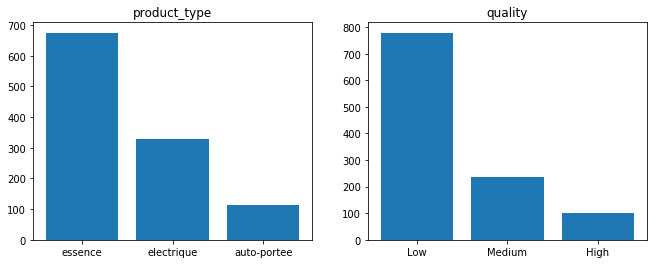

In [0]:
# Categorical features
cats = ["product_type", "quality"]
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
for cat, ax in zip(cats,axes):
    freqs = train.loc[:,cat].value_counts()
    ax.bar(freqs.index, freqs.values)
    ax.set_title(cat)

__Notes__:
- `product_type`: the bulk of mower market is consists of `essence` or diesel mowers.
- `quality`: the most frequent quality is as expected low, then medium an finnaly high, with roiughly the same distribution as `product_type`.

### Bi-variate analysis

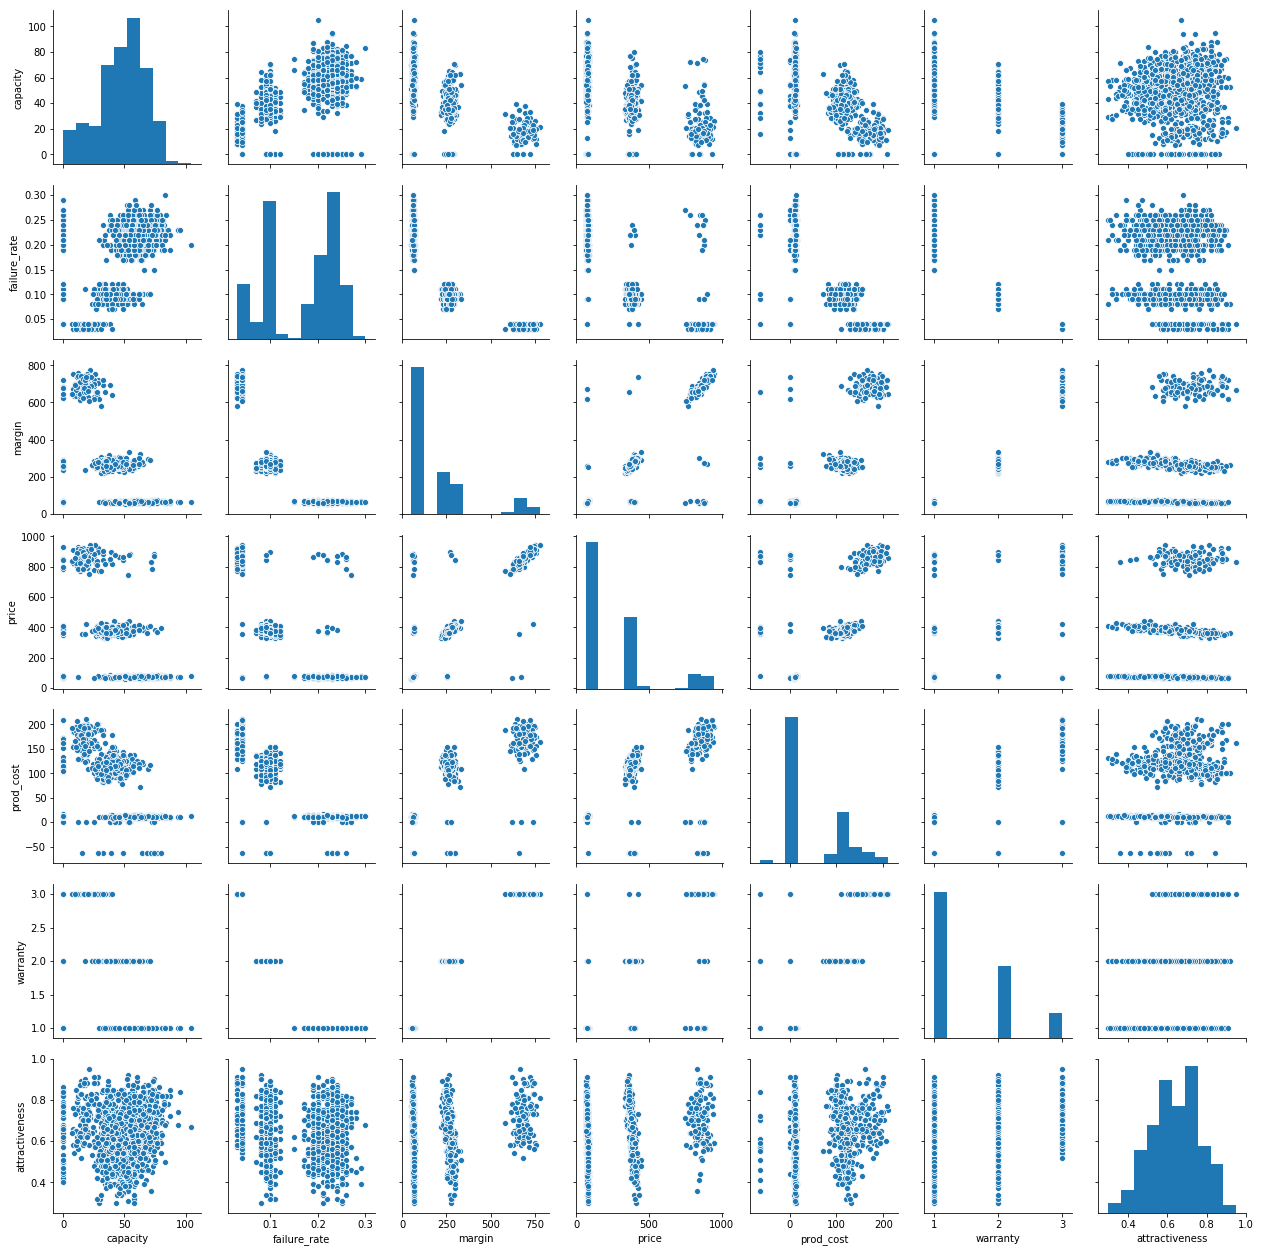

In [0]:
# Bi-variate analysis for numeric features
sns.pairplot(train.dropna());

__Notes__:

- The above shows a scatter matrix of all pairs of numeric features. Focusing on `attractiveness`, one can note:
    - `capacity` a slight unpward trend for large mower (capacity ~ 50L)
    - `failure_rate` downward trend: On average, the heigher is failure incidence, , the lower is the customer satisfaction.
    - `margin` upward trend:  the heigher is the margin, , the heigher is the product attractiveness.
    - `price` upward trend:  the heigher is the price, , the heigher is the product attractiveness.
    - `prod_cost` unclear trend
    - `warranty` upward trend:  the heigher is the warranty, , the heigher is the product attractiveness.
    
    These finding can be summarized in the correlation heatmap below
    
__Hypothesis__:

The underlying reasons of feature clustering and trends can be expliained mostly by `quality` and `product_type`

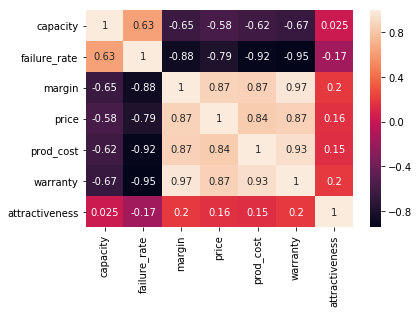

In [0]:
covariance_matrix = train.corr()
sns.heatmap(covariance_matrix, annot = True);

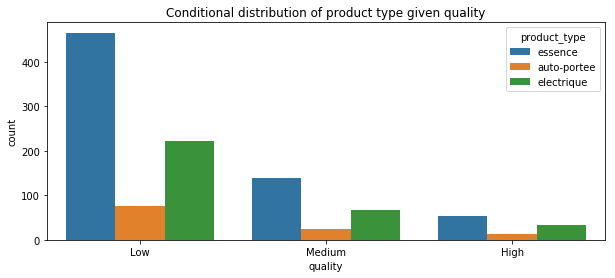

In [0]:
# Bi-variate analysis of categorical features
tmp = train.dropna()
fig, ax = plt.subplots(figsize = (10,4))

sns.countplot(tmp.quality, hue = tmp.product_type);
ax.set_title("Conditional distribution of product type given quality");

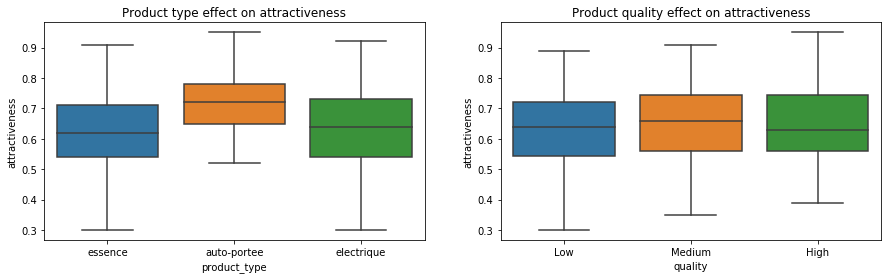

In [0]:
# Bi-variate analysis of categorical features and the target
tmp = train.dropna()
fig, axes = plt.subplots(1,2, figsize = (15,4))

sns.boxplot(tmp.product_type, train.attractiveness,ax = axes[0]);
axes[0].set_title('Product type effect on attractiveness');
sns.boxplot(tmp.quality, train.attractiveness,ax = axes[1]);
axes[1].set_title('Product quality effect on attractiveness');

### Multi variate analysis

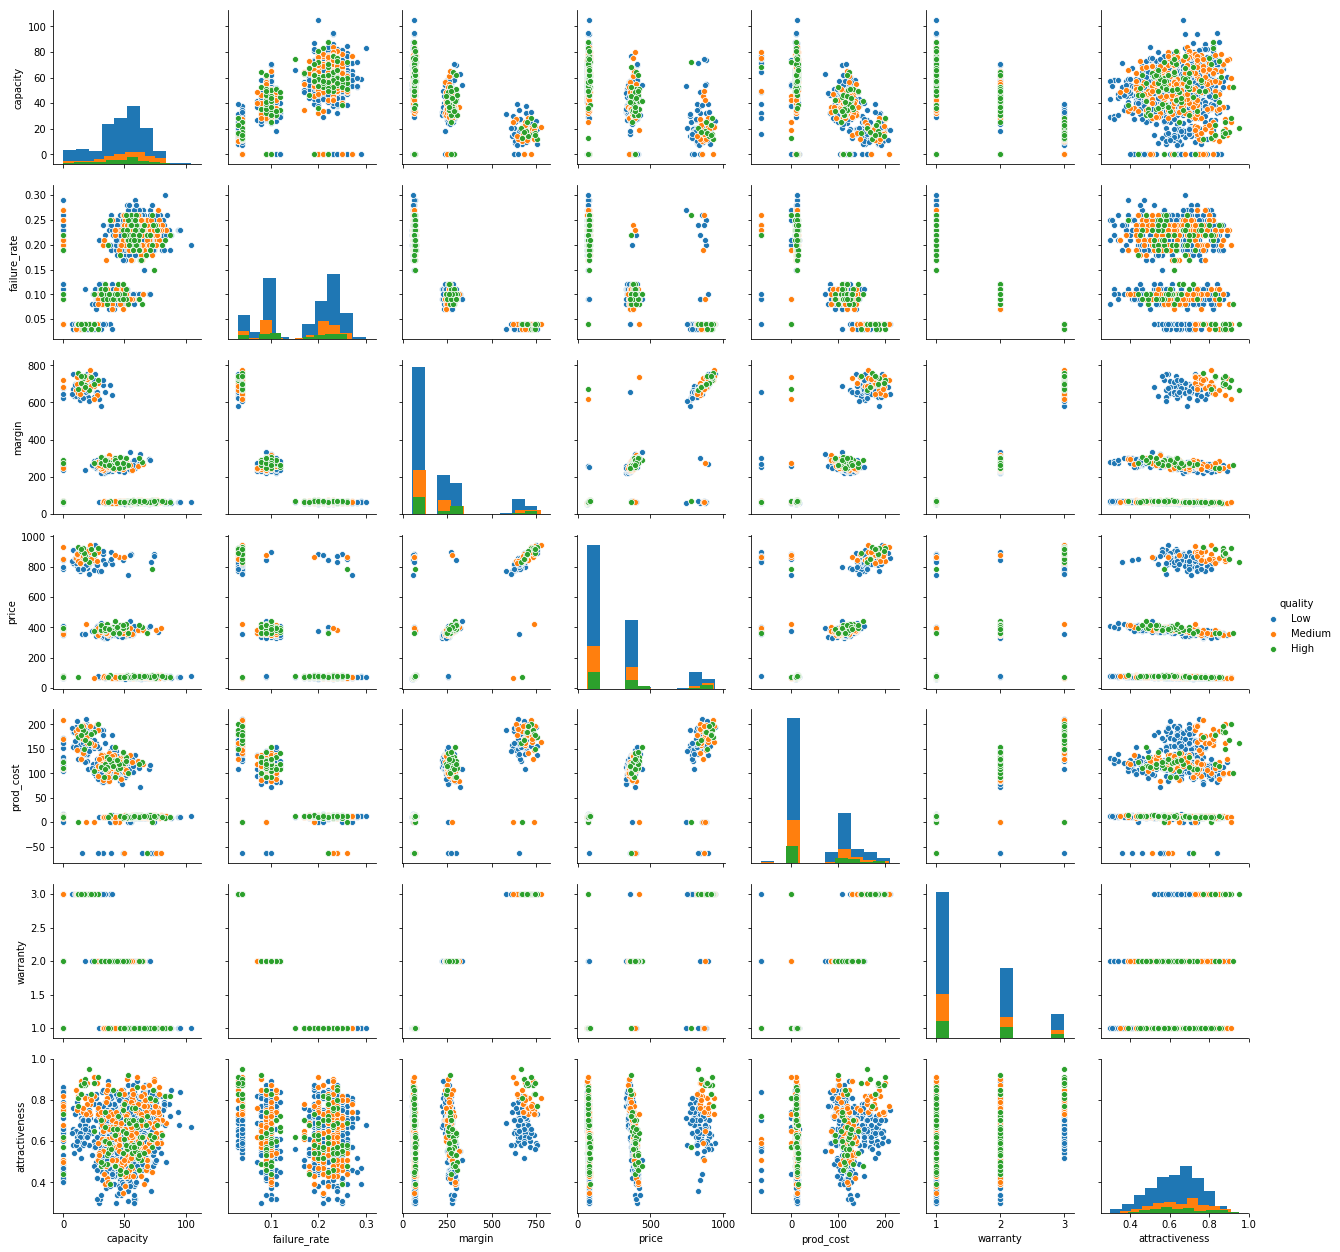

In [0]:
tmp = train.dropna()
sns.pairplot(data=tmp,hue = "quality",diag_kind = "hist");

#  Exporting to figs dir
plt.savefig("./../figs/scatter_matrix_by_quality.png", dpi=300)

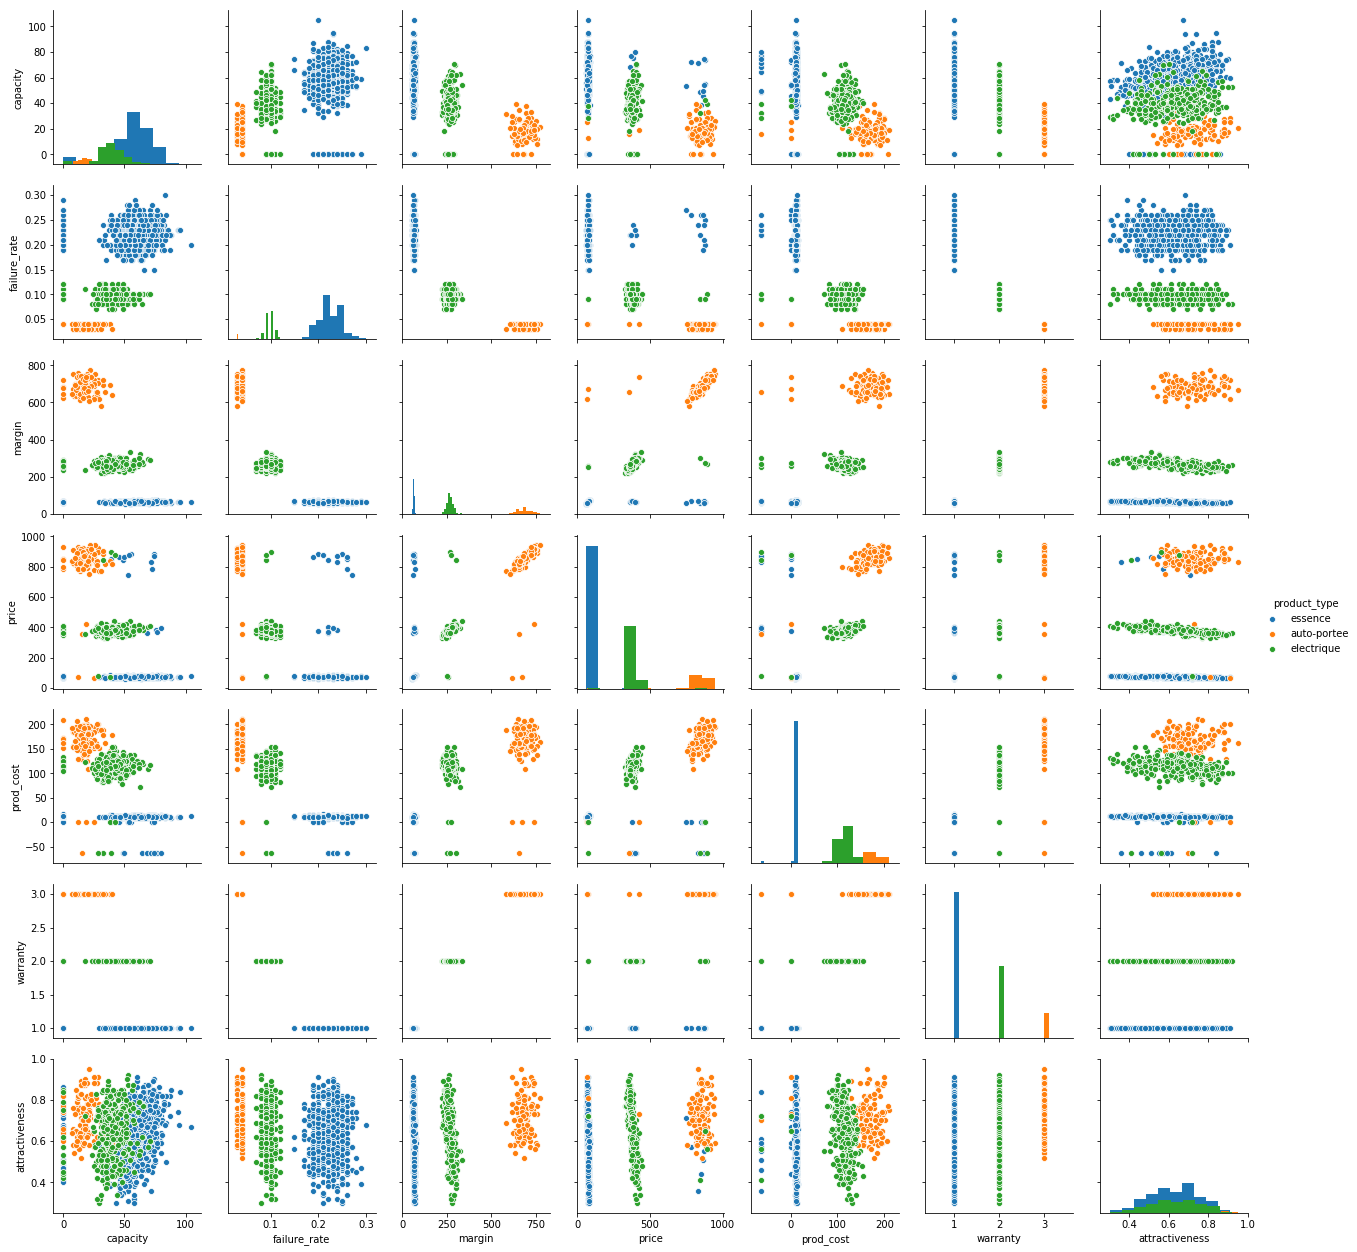

In [0]:
tmp = train.dropna()
sns.pairplot(data=tmp,hue = "product_type",diag_kind = "hist");

#  Exporting to figs dir
plt.savefig("./../figs/scatter_matrix_by_product_type.png", dpi=300)

I think this the most insigntful figure in the whole project that shows all the correlations and effect of sub-market on target feature but also the other ones.

In [0]:
# Checking the global structure

from sklearn.decomposition import PCA

pca = PCA()
tmp = train.dropna()

# categories
c1 = tmp.product_type.values
c2 = tmp.quality.values

# Keeping only numeric values
tmp = tmp.select_dtypes("number")

# Column names
cols = tmp.columns

X_num = tmp.values
princ_num = pca.fit_transform(X_num)

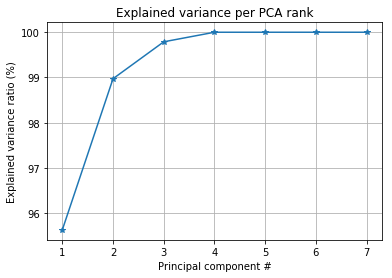

In [0]:
cum_expl_variance_ratio = 100*np.cumsum(pca.explained_variance_ratio_)
# sigular_values_sorted = sorted(pca.singular_values_, reverse= True)
n_components = np.arange(1,(pca.n_components_ + 1), dtype = np.int)
plt.plot(n_components, cum_expl_variance_ratio, '*-')
plt.xlabel("Principal component #")
plt.title("Explained variance per PCA rank")
plt.ylabel("Explained variance ratio (%)")
plt.grid(True)
plt.show()

__Remark: The data set is highly corrolated, the first 2 principal components explain up to 99% of the variance of the entire data set !__

In [0]:
transition_matrix = pd.DataFrame(pca.components_, columns=cols)
transition_matrix

,capacity,failure_rate,margin,price,prod_cost,warranty,attractiveness
0,-0.040105,-0.000204,0.585505,0.791882,0.168801,0.002041,0.000070
1,0.050242,0.000201,-0.771600,0.609990,-0.173250,-0.002245,-0.000229
2,0.084594,0.000695,0.245090,0.028859,-0.965365,-0.003333,0.000293
3,-0.994338,-0.000061,-0.041753,0.001337,-0.097695,0.000398,-0.001622
4,-0.001151,-0.059897,-0.001140,0.000012,-0.001481,0.384563,0.921151
5,0.001445,-0.170307,-0.001774,-0.000171,-0.003695,0.905332,-0.389039
6,0.000040,0.983569,-0.000273,-0.000009,0.000016,0.180182,-0.011267


In [0]:
transition_matrix.attractiveness.apply(np.abs).sort_values(ascending = False)
# To grasp the dynamics of attractiveness, we will look also to principal axis 4 and 5

4    0.921151
5    0.389039
6    0.011267
3    0.001622
2    0.000293
1    0.000229
0    0.000070
Name: attractiveness, dtype: float64

In [0]:
def draw_vector(text, v0, v1,ax=None):
    """
    Draw a vector on an ax
    """
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='<-',
                    linewidth=2,
                    shrinkA=0,
                    shrinkB=0)
    ax.annotate(text, v1, v0, arrowprops=arrowprops, fontsize = 10)

In [0]:
def project_to_sub_space(ax_1,ax_2):
    """
    Project the current data set in <(ax_1,ax_2)> to analyse 
    features correlations more easily
    ax_1: int
    ax_2: int
    """
    fig, axes = plt.subplots(1,2,figsize = (16,6))
    cats = {"product_type":c1, "quality":c2}
    sub_transition_matrix = transition_matrix.loc[[ax_1,ax_2],:]
    scale = princ_num[:,[ax_1, ax_2]]
    scale = (scale.max() - scale.min())/4
    length = sub_transition_matrix.apply(lambda x: np.linalg.norm(x))
    length_max = length.max()
    rel_length = length/length_max

    for cat,ax in zip(cats,axes):

        sns.scatterplot(princ_num[:,ax_1],
                        princ_num[:,ax_2],
                        hue = cats[cat],
                        ax = ax);

        for i, col in enumerate(cols):

            vector = sub_transition_matrix[col]*scale/length[col]
#             print(rel_length[col])
            draw_vector(col,vector,(0,0), ax)

        ax.set_title(f"Projection in 2D feature space colored by {cat}");
        ax.set_xlabel(f"Component #{ax_1 + 1}");
        ax.set_ylabel(f"Component #{ax_2 + 1}");


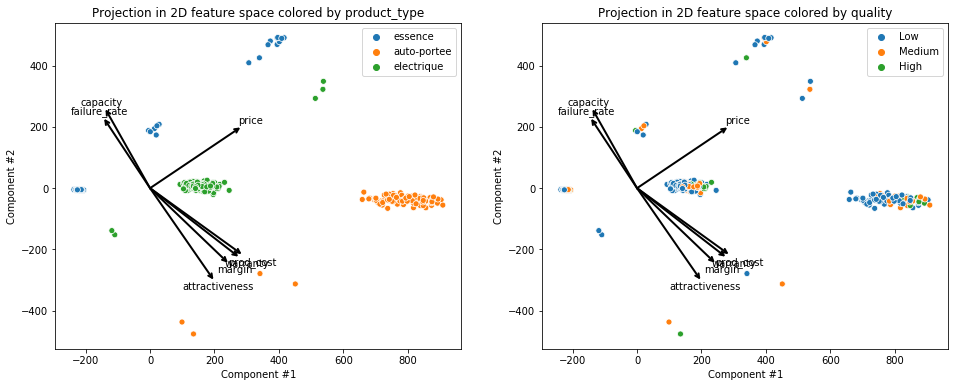

In [0]:
ax_1, ax_2 = (0,1)
project_to_sub_space(ax_1,ax_2)

- These two figures are plotted in 2D feature space that accounts for more than 99% of training data variance, so the conclusion drawn here are pretty valid as a whole.


- These two charts are colored by the categorical variables `prodcut_type` and `quality`:

    - `prouct_type`:
        - On average, the customers perference is as follows: "auto-porte" > "electrique" > "essence" 
        - Attractiveness is negatively correlated to `failure_rate` and `capacity`which are strongly correlated.  
        - Attractiveness is positevely correlated to `margin` and `warranty`.  


 - 